## Importing Libraries

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D ,BatchNormalization
from keras.preprocessing import image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

## Dataset Visualization & Preprocessing

In [ ]:
img_dir = "data/Brain Tumor Data Set/Brain Tumor Data Set/"
for expression in os.listdir(img_dir):
    print(expression, "folder contians\t\t", len(os.listdir(img_dir + expression)), 'images')

Brain Tumor folder contians		 2513 images
Healthy folder contians		 2087 images


In [11]:
BATCH_SIZE = 64
IMAGE_SIZE = 150
input_shape = (150,150,1)

Data_gen = ImageDataGenerator(rescale = 1.0/255,
                              validation_split = 0.2)

train_gen = Data_gen.flow_from_directory(img_dir,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "grayscale",
                                        shuffle=True,
                                        class_mode = "binary",
                                        subset = "training")


valid_gen = Data_gen.flow_from_directory(img_dir,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "grayscale",
                                        shuffle=False,
                                        class_mode = "binary",
                                        subset = "validation")

labels = train_gen.class_indices

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


## Model Definition

### Tuning Hyperameters

In [14]:
model = Sequential([
    Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512,activation="relu"),
    Dropout(0.2),
    Dense(1,activation="sigmoid")])

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics = ['accuracy']
              )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

## Model Training

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights = True)
checkpoint = ModelCheckpoint("Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(train_gen,
                    verbose=1,
                    epochs=100,
                    validation_data=valid_gen,
                    callbacks = [early_stopping,checkpoint]
                    )

Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.7656
Epoch 1: val_accuracy improved from -inf to 0.85201, saving model to Model.h5
58/58 [==============================] - 65s 1s/step - loss: 0.4708 - accuracy: 0.7656 - val_loss: 0.3697 - val_accuracy: 0.8520
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8921
Epoch 2: val_accuracy improved from 0.85201 to 0.85745, saving model to Model.h5
58/58 [==============================] - 11s 181ms/step - loss: 0.2780 - accuracy: 0.8921 - val_loss: 0.3008 - val_accuracy: 0.8575
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9432
Epoch 3: val_accuracy improved from 0.85745 to 0.96192, saving model to Model.h5
58/58 [==============================] - 9s 157ms/step - loss: 0.1484 - accuracy: 0.9432 - val_loss: 0.1012 - val_accuracy: 0.9619
Epoch 4/100
58/58 [==============================] - ETA: 0s - loss: 0.0847 - accur

## Plotting and Evaluation

In [17]:
train_loss, train_acc = model.evaluate(train_gen)
test_loss, test_acc   = model.evaluate(valid_gen)

15/15 [==============================] - 1s 91ms/step - loss: 0.0201 - accuracy: 0.9924


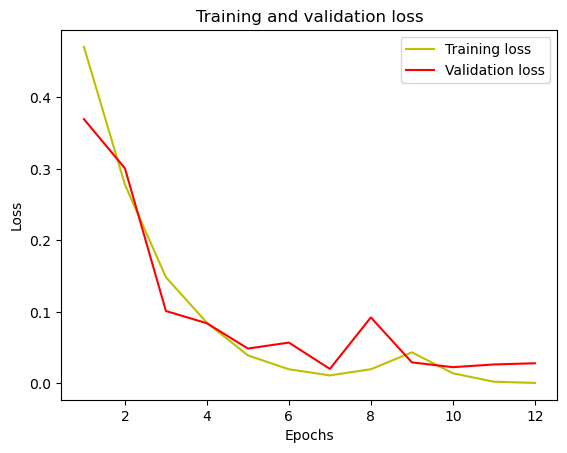

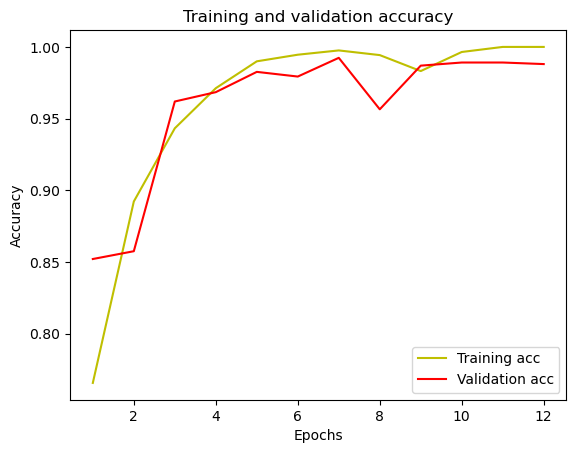

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

15/15 [==============================] - 1s 95ms/step


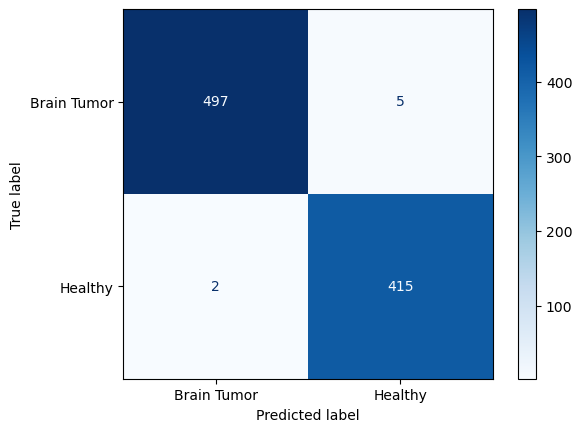

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       502
           1       0.99      1.00      0.99       417

    accuracy                           0.99       919
   macro avg       0.99      0.99      0.99       919
weighted avg       0.99      0.99      0.99       919



In [34]:
predictions = np.round(model.predict(valid_gen))
real = valid_gen.classes
cm = confusion_matrix(real, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=labels.keys())
cm_display.plot(cmap=plt.cm.Blues)
plt.show()



# Classification report
print("-----------------------------------------------------------------")
print(classification_report(real, predictions))